In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np 
import pandas as pd 
# Input data files are available in the read-only "../input/" directory

import os

In [2]:
!pip install nnAudio
!pip install efficientnet

     |████████████████████████████████| 43 kB 827 kB/s            
     |████████████████████████████████| 50 kB 1.6 MB/s            


In [3]:

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential, utils, optimizers, metrics
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from random import shuffle
from nnAudio.Spectrogram import CQT1992v2
import torch
from scipy import signal, fft
from efficientnet.tfkeras import EfficientNetB0, EfficientNetB1
import math
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter

TOP_INPUT_DIRECTORY = "../input/g2net-gravitational-wave-detection"
BATCH_SIZE = 128
EPOCHS = 2
EXAMPLE_IDENTIFIER_1 = "00000e74ad"
EXAMPLE_IDENTIFIER_0 = "00001f4945"
RANDOM_SAMPLE_SIZE = 1
PERFORM_FITTING = True
SAMPLING_FREQUENCY = 2048
SAMPLES_1 = 4096
SAMPLES_3 = 3 * SAMPLES_1
USE_TRAIN_SUBSET = False
USE_TEST_SUBSET = False
SUBSET_SIZE = 1024
LEARNING_RATE = 0.001
TRAIN_TEST_SPLIT = 0.95



# Utility functions

def make_array_cyclic(array):
    """Takes as input a 2d ndarray, and returns the same array but with the last
    array copied to the front (so array [[0], [1], [2]] -> [[2], [0], [1], [2]]
    This is so convolution layers can identifier features between measurements by
    sensors 0 and 2."""
    last_array = array[-1, :]
    reshaped_array = np.reshape(last_array, (1, last_array.shape[0]))

    return np.insert(array, 0, reshaped_array, 0)


def get_array(identifier, is_training=True):
    """Eg. Given identifier "00001f4945", returns array loaded from
    input/train/0/0/0/00001f4945.npy. If is_training is False, use test instead
    of train."""
    char0 = identifier[0]
    char1 = identifier[1]
    char2 = identifier[2]
    if is_training:
        path = f"{TOP_INPUT_DIRECTORY}/train/{char0}/{char1}/{char2}/{identifier}.npy"
    else:
        path = f"{TOP_INPUT_DIRECTORY}/test/{char0}/{char1}/{char2}/{identifier}.npy"
    return np.load(path)

def get_array_n(identifier, is_training=True):
    """Return hstack of signal, each signal normalised before stack."""
    arr = get_array(identifier, is_training)
    arr0 = arr[0]
    arr0 = arr0 / np.max(arr0)
    arr1 = arr[1]
    arr1 = arr1 / np.max(arr1)
    arr2 = arr[2]
    arr2 = arr2 / np.max(arr2)
    return np.hstack([arr0, arr1, arr2])

/opt/conda/lib/python3.7/site-packages/nnAudio/Spectrogram.py:7: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  category=Warning,


In [4]:
# A look and feel of the data.

targets = pd.read_csv(f"{TOP_INPUT_DIRECTORY}/training_labels.csv")
y = targets["target"].values

all_identifiers = targets["id"].values
identifiers_1 = targets[targets["target"] == 1]["id"].values
identifiers_0 = targets[targets["target"] == 0]["id"].values

# Choose a random few samples with signal and no-signal.
sample_ids_1 = np.random.choice(identifiers_1, RANDOM_SAMPLE_SIZE)
print(f"\nRandom samples with SIGNAL + NOISE: {sample_ids_1}")
sample_ids_0 = np.random.choice(identifiers_0, RANDOM_SAMPLE_SIZE)
print(f"\nRandom samples with ONLY NOISE: {sample_ids_0}")
print("\n")




Random samples with SIGNAL + NOISE: ['751dfa1642']

Random samples with ONLY NOISE: ['5bd031dc86']




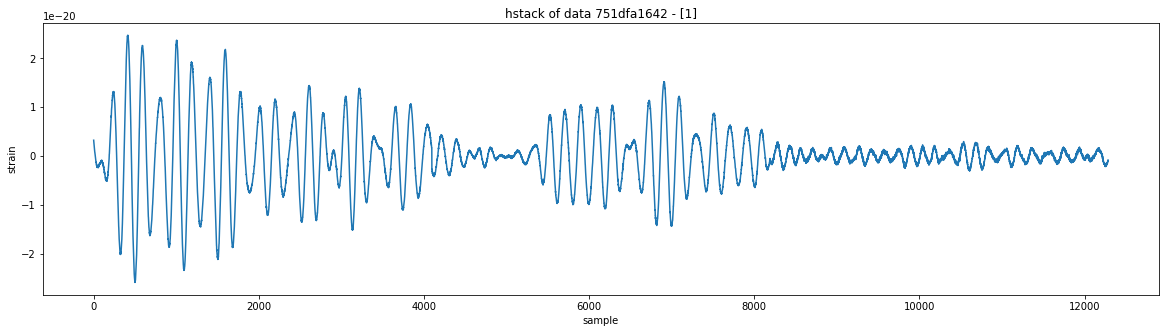

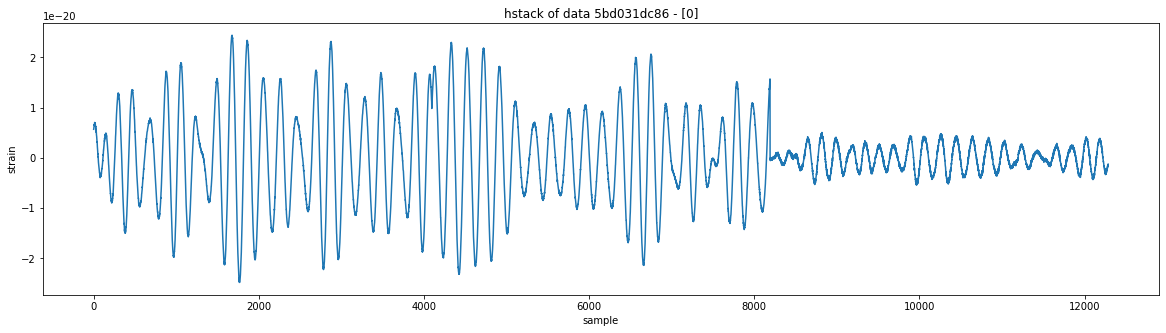

In [5]:
def plot_hstack(id, is_train=True):
    plt.figure(figsize=(20,5))
    plt.plot(np.hstack(get_array(id, is_train)))
    plt.xlabel("sample")
    plt.ylabel("strain")
    plt.title(f"hstack of data {id} - {targets[targets['id'] == id].target.values}")

for id in sample_ids_1:
    plot_hstack(id)
    
for id in sample_ids_0:
    plot_hstack(id)

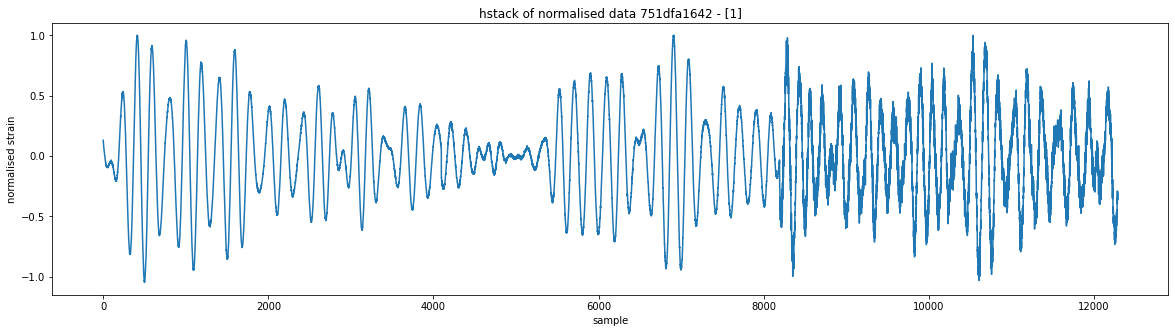

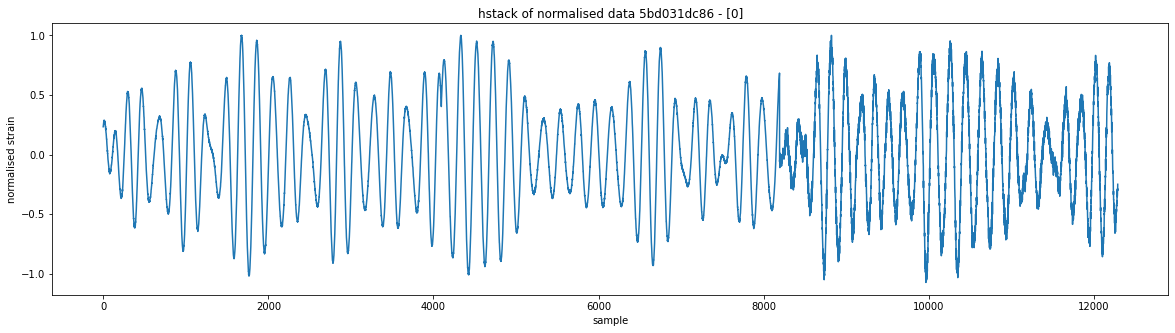

In [6]:
def plot_normalised_hstack(id, is_train=True):
    plt.figure(figsize=(20,5))
    plt.plot(get_array_n(id, is_train))
    plt.xlabel("sample")
    plt.ylabel("normalised strain")
    plt.title(f"hstack of normalised data {id} - {targets[targets['id'] == id].target.values}")

for id in sample_ids_1:
    plot_normalised_hstack(id)

for id in sample_ids_0:
    plot_normalised_hstack(id)

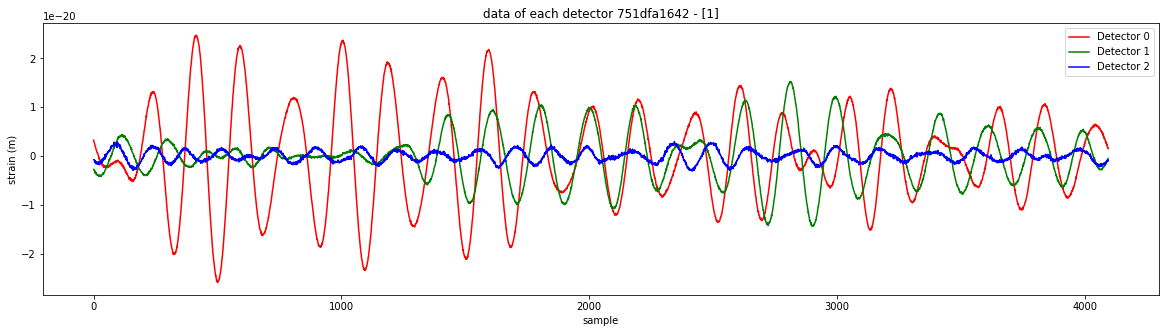

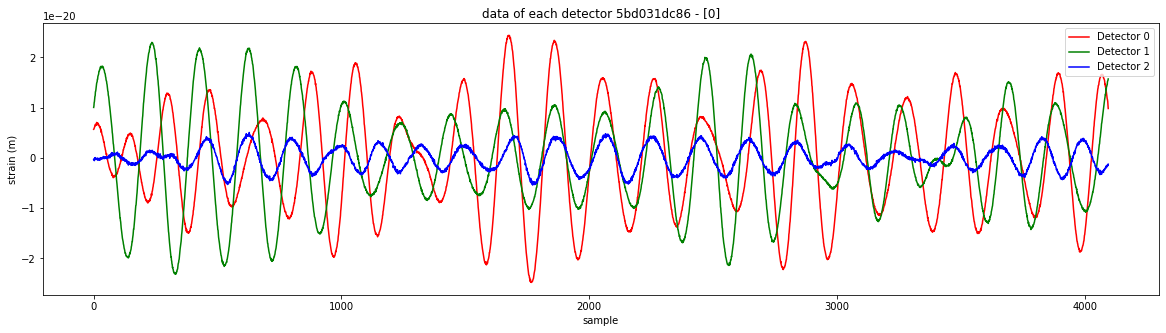

In [7]:
def plot_data_parallel(id, is_train=True):
    data = get_array(id, is_train)
    plt.figure(figsize=(20,5))
    plt.plot(data[0], color="red", label="Detector 0")
    plt.plot(data[1], color="green", label="Detector 1")
    plt.plot(data[2], color="blue", label="Detector 2")
    plt.xlabel("sample")
    plt.ylabel("strain (m)")
    plt.legend()
    plt.title(f"data of each detector {id} - {targets[targets['id'] == id].target.values}")
    
for id in sample_ids_1:
    plot_data_parallel(id)

for id in sample_ids_0:
    plot_data_parallel(id)

Spectrograms of the hstack'd data. Obvious peaks at 1/3 and 2/3 of the total time due to discontinuity between detector data.

/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)



nnAudio CQT1992 spectrogram shape: (69, 193, 1)



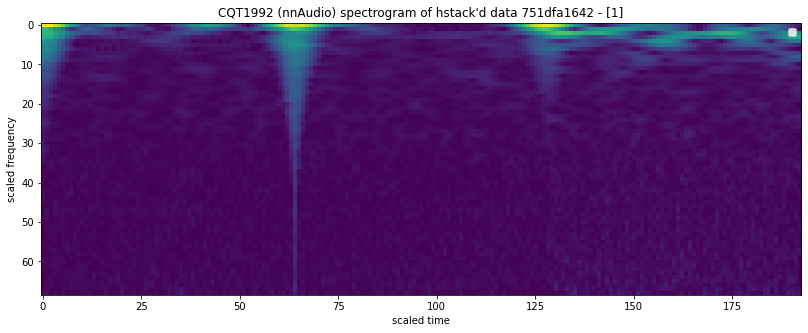

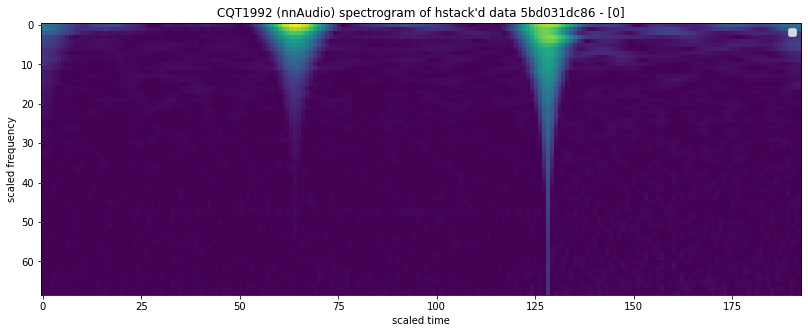

In [8]:
def get_cqt_spectrogram(id, is_train=True):
    cqt = CQT1992v2(sr=SAMPLING_FREQUENCY, hop_length=64, fmin=20, fmax=1024, bins_per_octave=12, norm=1, window='hann', center=True, pad_mode='reflect', trainable=False, output_format='Magnitude', verbose=False)
    waveform = np.hstack(get_array(id, is_train))

    waveform = waveform / np.max(waveform)
    waveform = torch.from_numpy(waveform).float()
    cqt_image = cqt(waveform)
    cqt_image = np.array(cqt_image)

    cqt_image = np.transpose(cqt_image, (1,2,0))
    return cqt_image

def plot_cqt_spectrogram(id, is_train=True):
    image = get_cqt_spectrogram(id, is_train)
    plt.figure(figsize=(20,5))
    plt.imshow(image)
    plt.xlabel("scaled time")
    plt.ylabel("scaled frequency")
    plt.legend()
    plt.title(f"CQT1992 (nnAudio) spectrogram of hstack'd data {id} - {targets[targets['id'] == id].target.values}")

cqt_image = get_cqt_spectrogram(EXAMPLE_IDENTIFIER_1)
print("")
print(f"nnAudio CQT1992 spectrogram shape: {cqt_image.shape}")
print("")

for id in sample_ids_1:
    plot_cqt_spectrogram(id)
    
for id in sample_ids_0:
    plot_cqt_spectrogram(id)

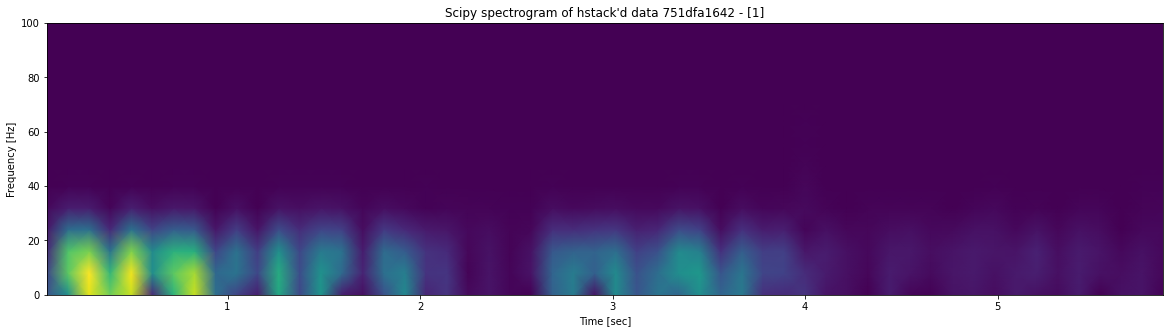

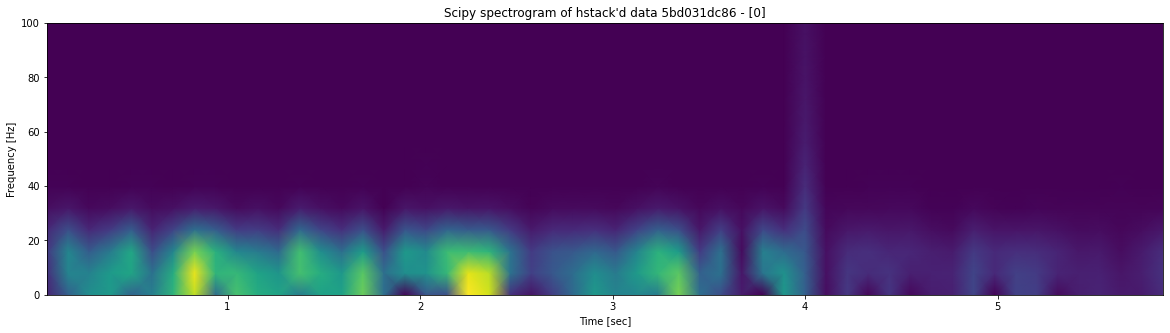

In [9]:
def get_scipy_spectrogram(id, is_train=True):
    waveform = np.hstack(get_array(id))
    waveform = waveform / np.max(waveform)
    (freq, time, intensity) = signal.spectrogram(waveform, SAMPLING_FREQUENCY, mode="magnitude", scaling="spectrum", window=('kaiser', 14))
    return (freq, time, intensity)

def plot_scipy_spectrogram(id, is_train=True):
    (f, t, i) = get_scipy_spectrogram(id, is_train)
    plt.figure(figsize=(20,5))
    plt.pcolormesh(t, f, i, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0,100)
    plt.title(f"Scipy spectrogram of hstack'd data {id} - {targets[targets['id'] == id].target.values}")
    plt.show()
    
for id in sample_ids_1:
    plot_scipy_spectrogram(id)
    
for id in sample_ids_0:
    plot_scipy_spectrogram(id)

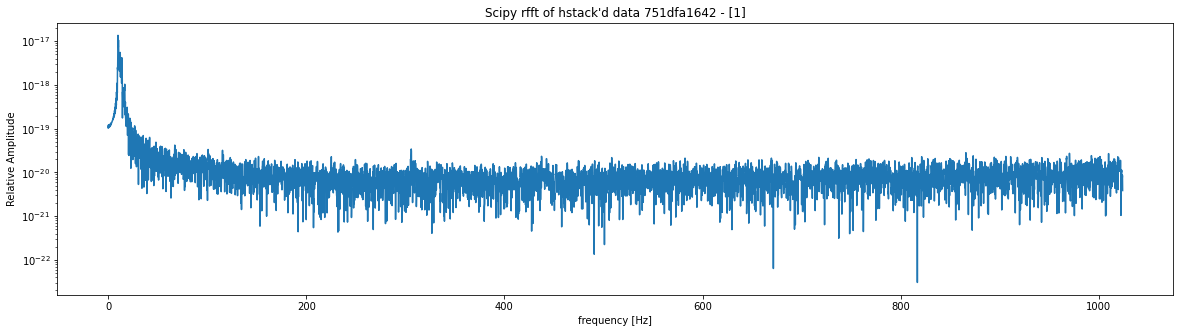

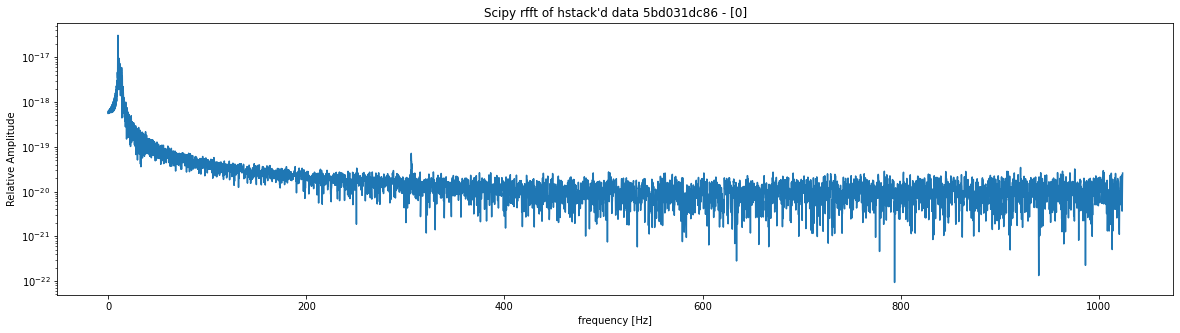

In [10]:
def get_scipy_fft(id, is_train=True):
    waveform = np.hstack(get_array(id))

    window = signal.hann(SAMPLES_3)
    return np.abs(fft.rfft(waveform * window))

def plot_scipy_fft(id, is_train=True):
    fast = get_scipy_fft(id)
    xf = fft.rfftfreq(SAMPLES_3, 1 / SAMPLING_FREQUENCY)
    plt.figure(figsize=(20,5))
    plt.yscale("log")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Relative Amplitude')
    plt.title(f"Scipy rfft of hstack'd data {id} - {targets[targets['id'] == id].target.values}")
    plt.plot(xf, fast)

for id in sample_ids_1:
    plot_scipy_fft(id)
    
for id in sample_ids_0:
    plot_scipy_fft(id)

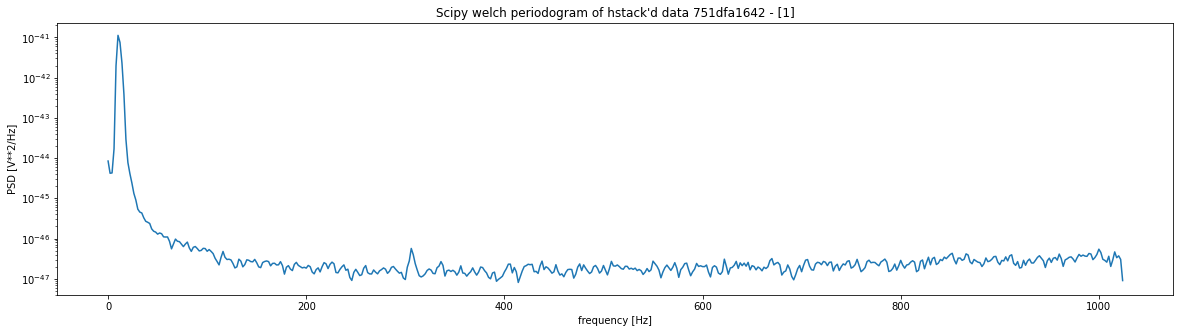

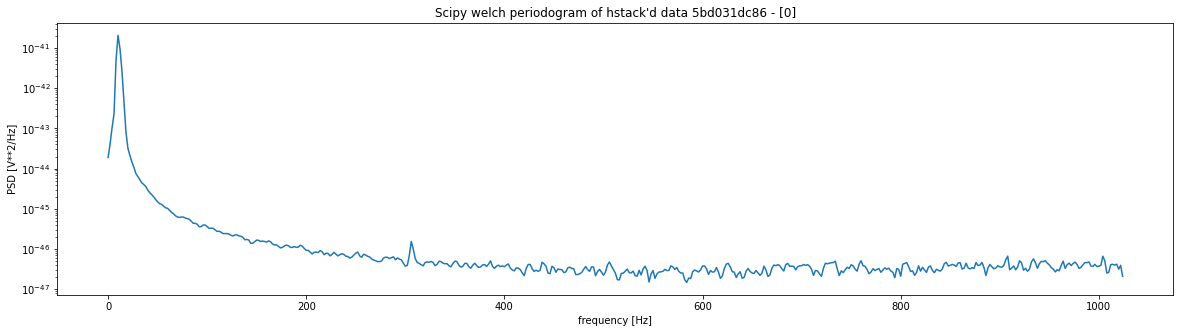

In [11]:
def get_welch_periodogram(id, is_train=True):
    f, Pxx_den = signal.welch(np.hstack(get_array(id)), SAMPLING_FREQUENCY, nperseg=1024)
    return f, Pxx_den

def plot_welch_periodogram(id, is_train=True):
    f, Pxx_den = get_welch_periodogram(id)
    plt.figure(figsize=(20,5))
    plt.semilogy(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title(f"Scipy welch periodogram of hstack'd data {id} - {targets[targets['id'] == id].target.values}")
    plt.show()

for id in sample_ids_1:
    plot_welch_periodogram(id)
    
for id in sample_ids_0:
    plot_welch_periodogram(id)

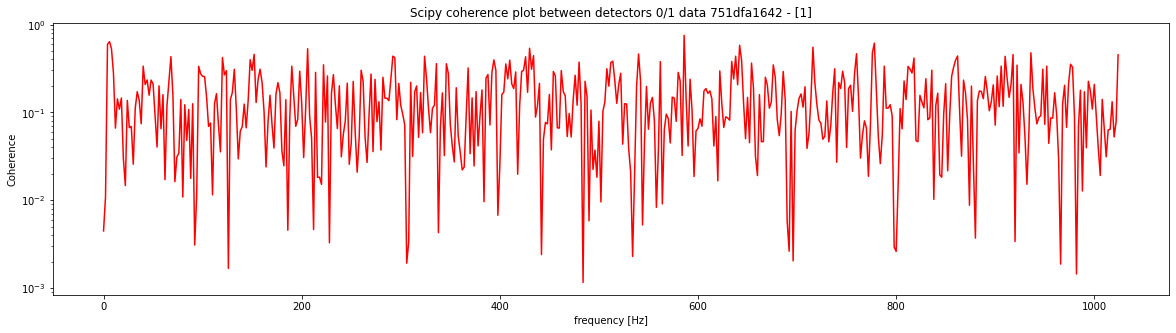

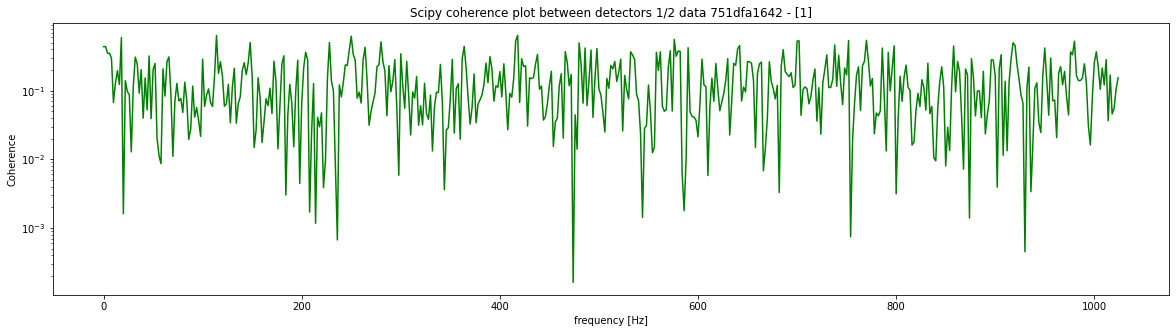

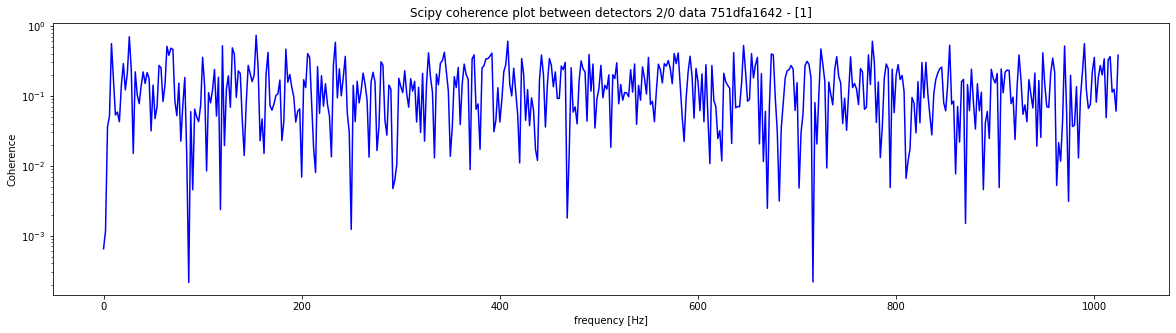

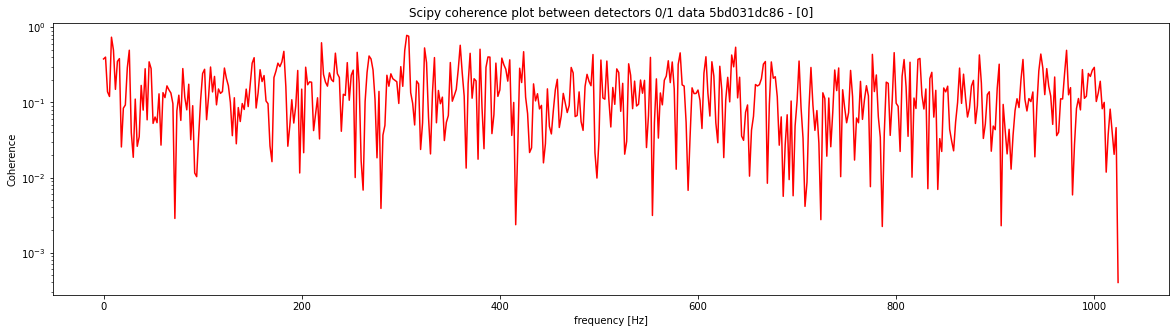

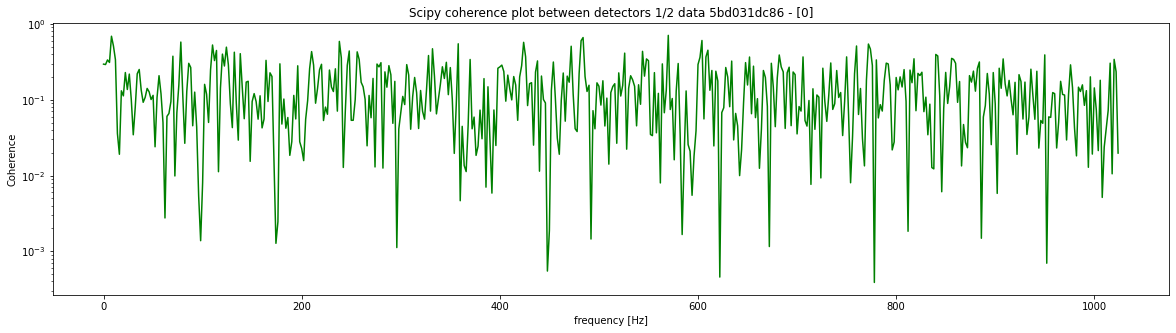

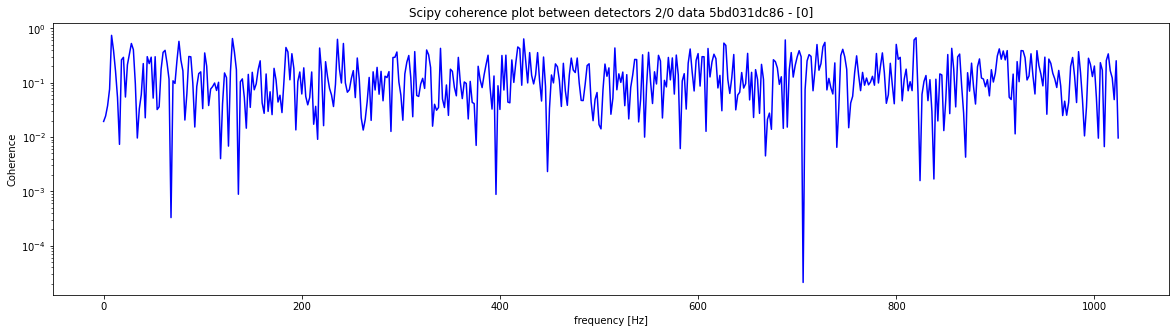

In [12]:
def get_coherence(id, is_train=True):
    """Coherence between 2 signals (in this case 0/1 - improve/extend for all combos)."""
    f0, Cxy0 = signal.coherence(get_array(id)[0], get_array(id)[1], SAMPLING_FREQUENCY, nperseg=1024)
    f1, Cxy1 = signal.coherence(get_array(id)[1], get_array(id)[2], SAMPLING_FREQUENCY, nperseg=1024)
    f2, Cxy2 = signal.coherence(get_array(id)[2], get_array(id)[0], SAMPLING_FREQUENCY, nperseg=1024)
    return (f0, Cxy0, f1, Cxy1, f2, Cxy2)

def get_coherence_data(id, is_train=True):
    f0, Cxy0, f1, Cxy1, f2, Cxy2 = get_coherence(id, is_train)
    return np.vstack((Cxy0, Cxy1, Cxy2))

def plot_coherence(f, Cxy, detectors, colour):
    plt.figure(figsize=(20,5))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Coherence')
    plt.semilogy(f, Cxy, color=colour)
    plt.title(f"Scipy coherence plot between detectors {detectors} data {id} - {targets[targets['id'] == id].target.values}")
    plt.show()

def plot_all_coherences(id, is_train=True):
    f0, Cxy0, f1, Cxy1, f2, Cxy2 = get_coherence(id)
    plot_coherence(f0,Cxy0, "0/1", "red")
    plot_coherence(f1,Cxy1, "1/2", "green")
    plot_coherence(f2,Cxy2, "2/0", "blue")

for id in sample_ids_1:
    plot_all_coherences(id)

for id in sample_ids_0:
    plot_all_coherences(id)

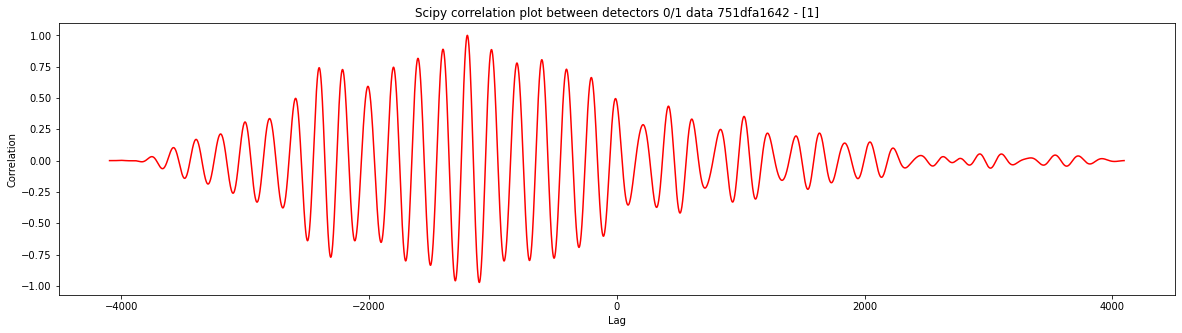

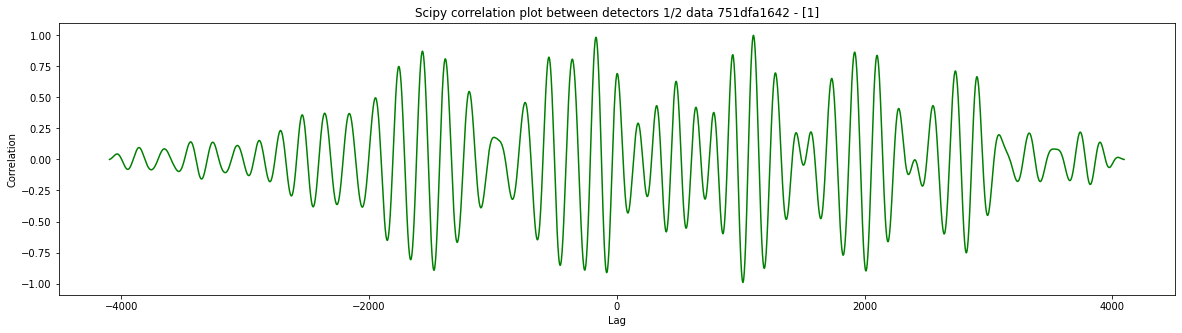

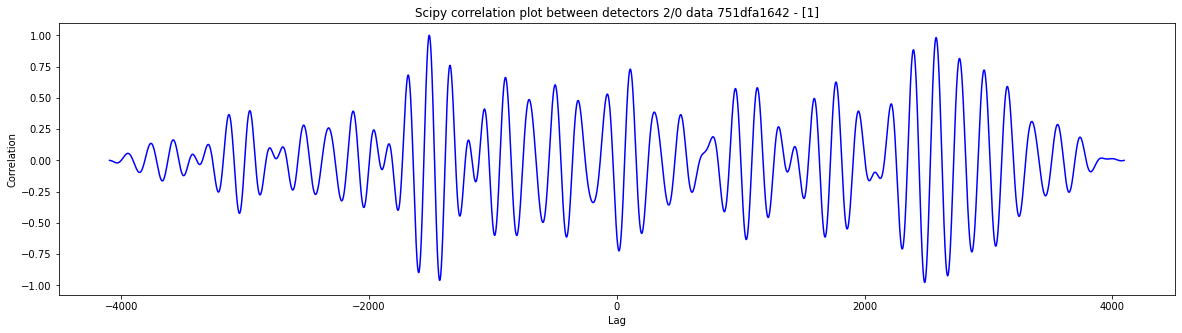

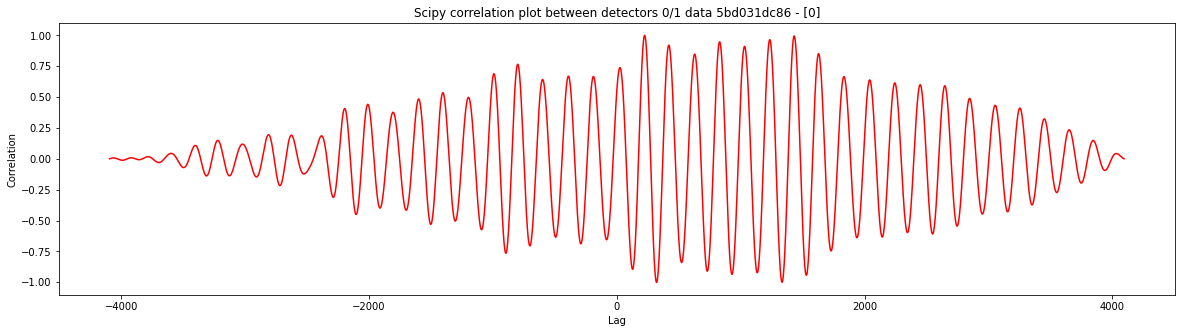

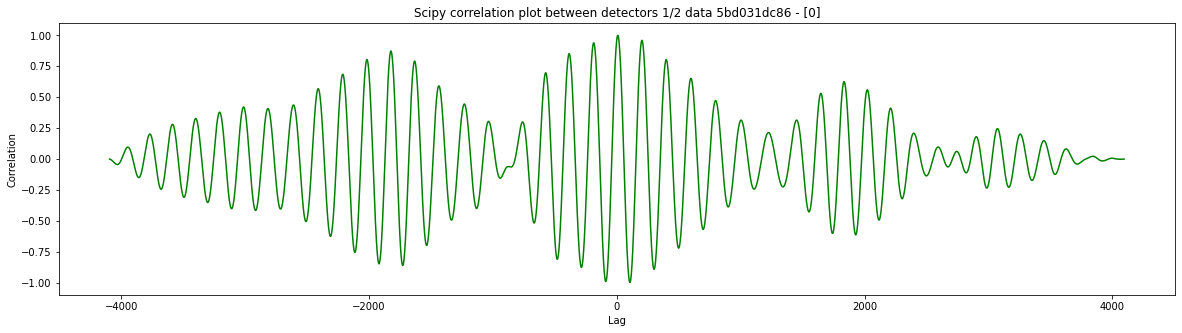

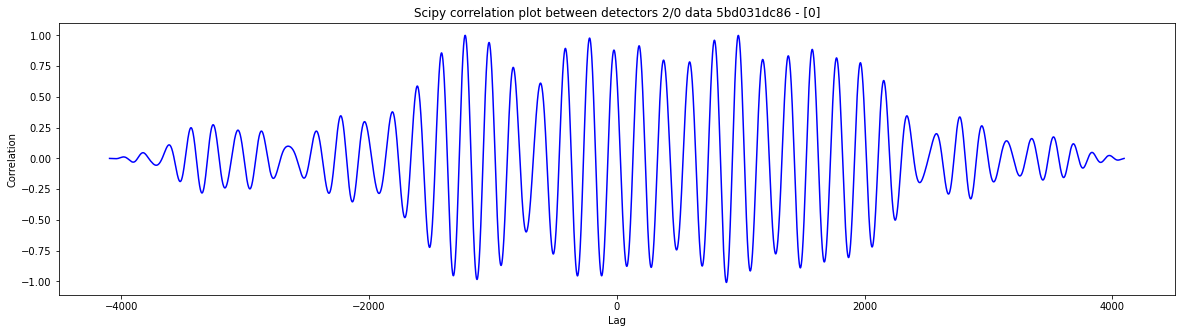

In [13]:
def get_correlation(id, is_train=True):
    samples = get_array(id, is_train)
    corr0 = signal.correlate(samples[0], samples[1])
    lags0 = signal.correlation_lags(len(samples[0]), len(samples[1]))
    corr0 /= np.max(corr0)
    
    corr1 = signal.correlate(samples[1], samples[2])
    lags1 = signal.correlation_lags(len(samples[1]), len(samples[2]))
    corr1 /= np.max(corr1)
    
    corr2 = signal.correlate(samples[2], samples[0])
    lags2 = signal.correlation_lags(len(samples[2]), len(samples[0]))
    corr2 /= np.max(corr2)
    return (lags0, corr0, lags1, corr1, lags2, corr2)

def get_correlation_data(id, is_train=True):
    lags0, corr0, lags1, corr1, lags2, corr2 = get_correlation(id, is_train)
    return np.vstack((corr0, corr1, corr2))

def plot_correlation(lags, corr, detectors, colour):
    plt.figure(figsize=(20,5))
    plt.title(f"Scipy correlation plot between detectors {detectors} data {id} - {targets[targets['id'] == id].target.values}")
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.plot(lags, corr, color=colour)

def plot_all_correlations(id, is_train=True):
    lags0, corr0, lags1, corr1, lags2, corr2 = get_correlation(id, is_train)
    plot_correlation(lags0, corr0, "0/1", "red")
    plot_correlation(lags1, corr1, "1/2", "green")
    plot_correlation(lags2, corr2, "2/0", "blue")

for id in sample_ids_1:
    plot_all_correlations(id)

for id in sample_ids_0:
    plot_all_correlations(id)

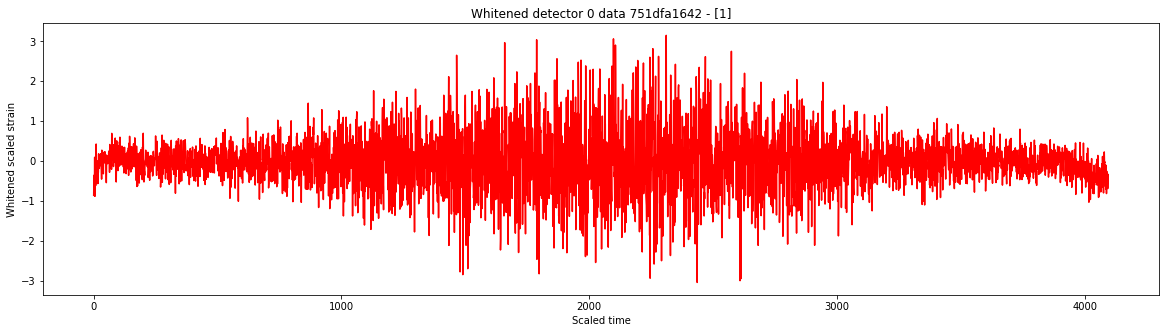

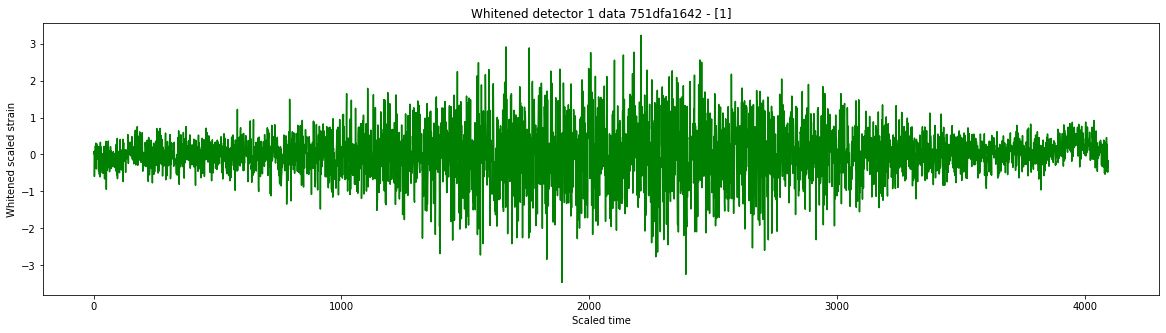

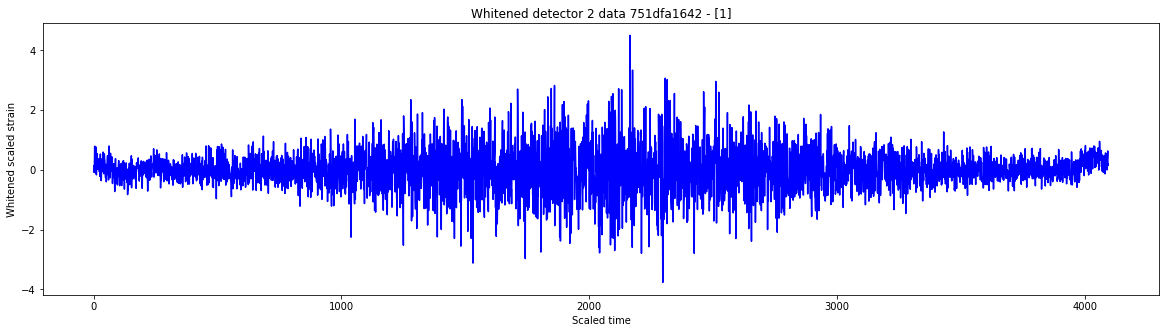

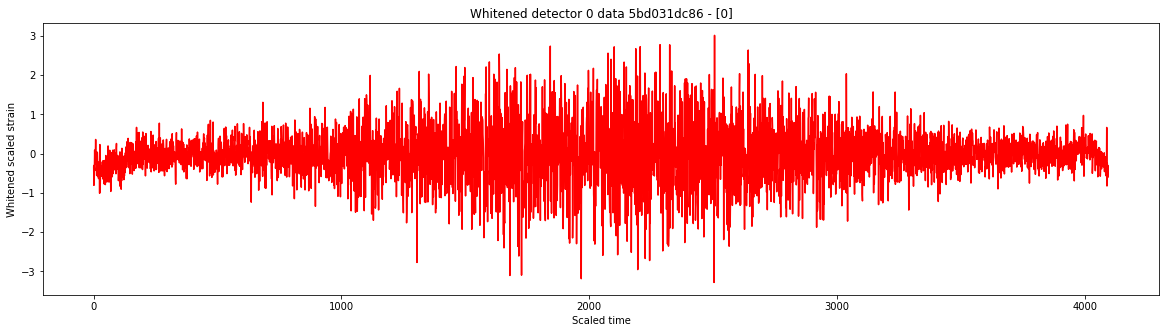

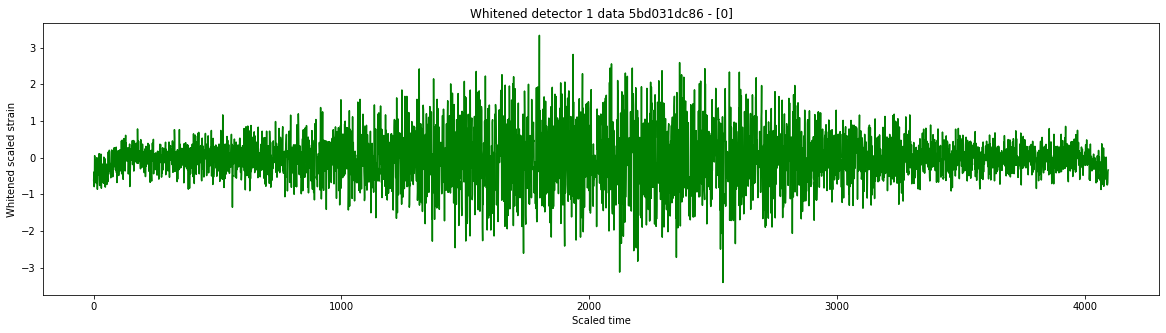

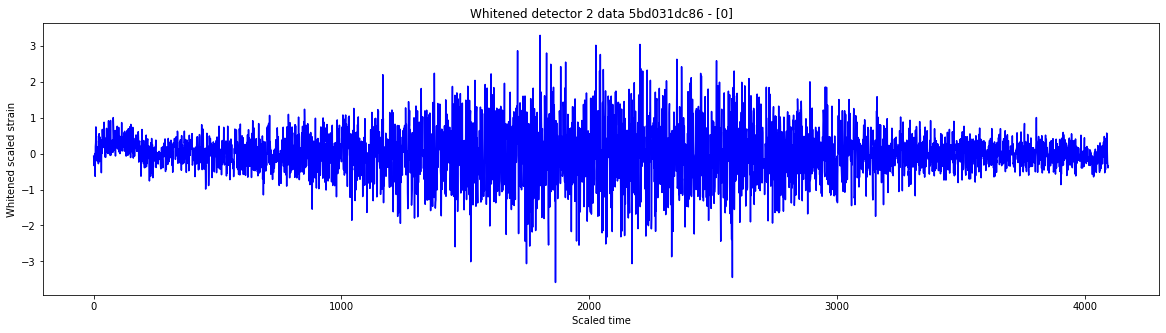

In [14]:
# Whitening
def whiten(waveform):
    """Whitens a signal - fourier transform, divide by PSD, inverse fourier transform."""
    window = signal.hann(waveform.size)
    spectrum = fft.fft(waveform * window)
    mag = np.sqrt(np.real(spectrum*np.conj(spectrum)))
    return np.real(fft.ifft(spectrum/mag)) * np.sqrt(len(waveform)/2)


def get_whitened_data(id, detector, is_train=True):
    return whiten(get_array(id, is_train)[detector])

def plot_whitened_data(data, detector, colour):
    plt.figure(figsize=(20,5))
    plt.title(f"Whitened detector {detector} data {id} - {targets[targets['id'] == id].target.values}")
    plt.xlabel('Scaled time')
    plt.ylabel('Whitened scaled strain')
    plt.plot(data, color=colour)
    
def plot_all_whitened_data(id, is_train=True):
    whitened_data0 = get_whitened_data(id, 0, is_train)
    whitened_data1 = get_whitened_data(id, 1, is_train)
    whitened_data2 = get_whitened_data(id, 2, is_train)

    plot_whitened_data(whitened_data0,"0", "red")
    plot_whitened_data(whitened_data1,"1", "green")
    plot_whitened_data(whitened_data2,"2", "blue")

for id in sample_ids_1:
    plot_all_whitened_data(id)

for id in sample_ids_0:
    plot_all_whitened_data(id)

/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


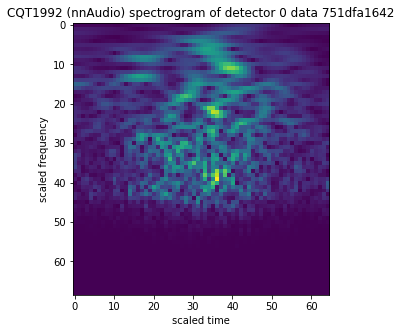

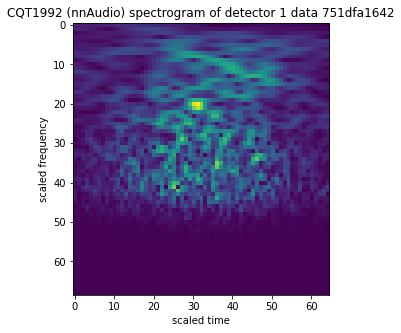

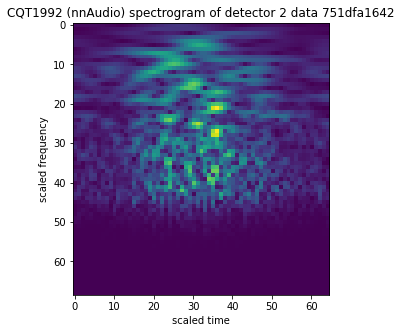

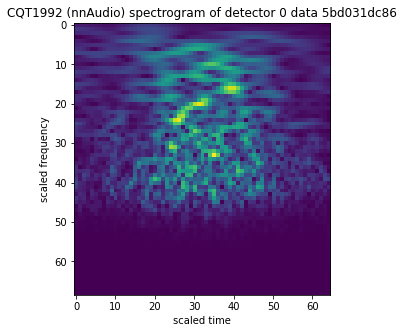

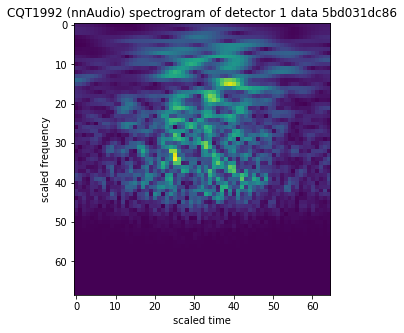

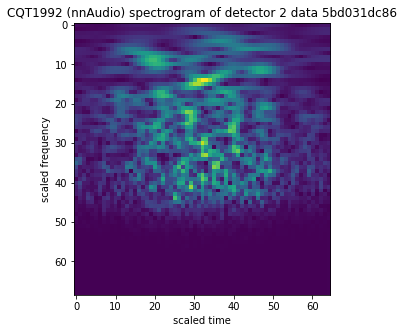

In [15]:
# Bandpass filtering (+ whitening)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_cqt_spectrogram_of_data(data):
    cqt = CQT1992v2(sr=SAMPLING_FREQUENCY, hop_length=64, fmin=20, fmax=1024, bins_per_octave=12, norm=1, window='hann', center=True, pad_mode='reflect', trainable=False, output_format='Magnitude', verbose=False)

    waveform = data
    waveform = waveform / np.max(waveform)
    waveform = torch.from_numpy(waveform).float()
    cqt_image = cqt(waveform)
    cqt_image = np.array(cqt_image)

    cqt_image = np.transpose(cqt_image, (1,2,0))
    return cqt_image

def plot_cqt_spectrogram_of_data(data, detector):
    image = get_cqt_spectrogram_of_data(data)
    plt.figure(figsize=(20,5))
    plt.imshow(image)
    plt.xlabel("scaled time")
    plt.ylabel("scaled frequency")
    plt.title(f"CQT1992 (nnAudio) spectrogram of detector {detector} data {id}")
    
def plot_all_whitened_bandpassed_spectrograms(id, lowcut=50, highcut=500, is_train=True):
    whitened_data0 = get_whitened_data(id, 0, is_train)
    whitened_data1 = get_whitened_data(id, 1, is_train)
    whitened_data2 = get_whitened_data(id, 2, is_train)

    bandpassed_data0 = butter_bandpass_filter(whitened_data0, lowcut, highcut, whitened_data0.size)
    bandpassed_data1 = butter_bandpass_filter(whitened_data1, lowcut, highcut, whitened_data1.size)
    bandpassed_data2 = butter_bandpass_filter(whitened_data2, lowcut, highcut, whitened_data2.size)
    
    plot_cqt_spectrogram_of_data(bandpassed_data0,"0")
    plot_cqt_spectrogram_of_data(bandpassed_data1,"1")
    plot_cqt_spectrogram_of_data(bandpassed_data2,"2")

for id in sample_ids_1:
    plot_all_whitened_bandpassed_spectrograms(id)

for id in sample_ids_0:
    plot_all_whitened_bandpassed_spectrograms(id)

To summarise so far, no signal "jumps out" to the naked eye, by considering various time-domain / frequency-domain plots. This highlights the non-trivial nature of this data science problem.

In [16]:
# Shapes of some of the data considered.

arr = get_array(EXAMPLE_IDENTIFIER_1)
print("\n")
print(f"Shape of array.shape: {arr.shape}")
print(f"Shape of array[0].shape: {arr[0].shape}")
print(f"Shape of np.hstack(array).shape: {np.hstack(arr).shape}")
print(f"Shape of np.vstack(array).shape: {np.vstack(arr).shape}")
print("\n")
(f, t, i) = get_scipy_spectrogram(EXAMPLE_IDENTIFIER_1)
print(f"Shape of scipy spectrogram (get_scipy_spectrogram) time (t of f,t,i): {t.shape}")
print(f"Shape of scipy spectrogram (get_scipy_spectrogram) frequency (f of f,t,i): {f.shape}")
print(f"Shape of scipy spectrogram (get_scipy_spectrogram) intensity (i=(f,t) of f,t,i): {i.shape}")
print(f"Shape of nnAudio CQT1992 spectrogram (get_cqt_spectrogram) (t, f): {get_cqt_spectrogram(EXAMPLE_IDENTIFIER_1).shape}")
print(f"Shape of Coherence data (get_coherence_data) shape: {get_coherence_data(EXAMPLE_IDENTIFIER_1).shape}")
print(f"Shape of Correlation data (get_correlation_data) shape: {get_correlation_data(EXAMPLE_IDENTIFIER_1).shape}")



Shape of array.shape: (3, 4096)
Shape of array[0].shape: (4096,)
Shape of np.hstack(array).shape: (12288,)
Shape of np.vstack(array).shape: (3, 4096)


Shape of scipy spectrogram (get_scipy_spectrogram) time (t of f,t,i): (54,)
Shape of scipy spectrogram (get_scipy_spectrogram) frequency (f of f,t,i): (129,)
Shape of scipy spectrogram (get_scipy_spectrogram) intensity (i=(f,t) of f,t,i): (129, 54)
Shape of nnAudio CQT1992 spectrogram (get_cqt_spectrogram) (t, f): (69, 193, 1)
Shape of Coherence data (get_coherence_data) shape: (3, 513)
Shape of Correlation data (get_correlation_data) shape: (3, 8191)


In [17]:
# General Dataset generator, to be extended with specific implementations of fetching sample/batch

class DataSetGenerator(Sequence):
    """Allows batch-loading of the ~50GB training data so we don't exhaust RAM."""

    def get_sample(self, id, is_train):
        """Needs to be implemented by child."""
        pass
    
    def __init__(self, identifiers, y=None, batch_size=256,
        shuffle=True, no_channels=1, no_classes=10, name="Unknown DataSet"):
        """Provided custom parameters for DataGenerator. At minimum, input an array
        of identifiers. If training, input the targets values also."""
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.identifiers = identifiers
        self.y = y
        self.name = name
        if y is not None:
            self.is_training = True
        else:
            self.is_training = False
        self.shape = self.get_sample(self.identifiers[0], self.is_training).shape
        print(f"{self.name} - Shape of each sample: {self.shape}\n")


    def __len__(self):
        """States number of batches per epoch (rounds up)."""

        return math.ceil(len(self.identifiers)/self.batch_size)

    def __getitem__(self, index):
        """Return batch of X (and y if training). Can be overidden in child if model input shape requires."""
        batch_ids = self.identifiers[index * self.batch_size:(index + 1) * self.batch_size]
        if self.y is not None:
            batch_y = self.y[index * self.batch_size: (index + 1) * self.batch_size]
        
        list_x = np.array([self.get_sample(x, self.is_training) for x in batch_ids])

        batch_X = np.stack(list_x)

        if self.is_training:
            return batch_X, batch_y
        else:
            return batch_X

    def on_epoch_end(self):
        """Shuffle at the end of each epoch."""
        pass
        if self.shuffle and self.is_training:
            ids_y = list(zip(self.identifiers, self.y))
            shuffle(ids_y)
            self.identifiers, self.y = list(zip(*ids_y))

In [18]:
class TimeSeriesDataSetGenerator(DataSetGenerator):
    """Inherits from DataSetGenerator class, methods to get sample and therefore batch are implemented, simply
    fetching the raw samples of 3x4096 ndarrays."""
    
    def get_sample(self, id, is_train):
        """Return 3x4096 ndarray (time-series data)."""
        return make_array_cyclic(get_array(id, is_train))
    

In [19]:
class Cqt1992DataSetGenerator(DataSetGenerator):
    """Inherits from DataSetGenerator class, methods to get sample and therefore batch are implemented, fetches
    CQT1992 spectrogram of the hstack'd arrays."""
    
    def get_sample(self, id, is_train):
        """Return CQT1992 spectrogram."""
        return get_cqt_spectrogram(id, is_train)
    
    def __getitem__(self, index):
        """Return batch of X (and y if training). Can be overidden in child if model input shape requires."""
        batch_ids = self.identifiers[index * self.batch_size:(index + 1) * self.batch_size]
        if self.y is not None:
            batch_y = self.y[index * self.batch_size: (index + 1) * self.batch_size]

       
        list_x = np.array([self.get_sample(x, self.is_training) for x in batch_ids])
        
        batch_X = np.stack(list_x)

        if self.is_training:
            return batch_X, batch_y
        else:
            return batch_X

In [20]:
def get_basic_cnn_model(shape):
    """Returns compiled model (callbacks, history, fitting etc not done here)."""

    model = Sequential([
        layers.InputLayer(input_shape=(shape[0], shape[1], 1), name="Input"),
        layers.Conv2D(3, (2,1024), strides=(1,512), padding='same', name="Conv2D_1"),
        layers.MaxPooling2D(pool_size=(2,4), strides=(1, 2), padding='valid', name="MaxPooling_1"),
        
        layers.Flatten(),
        layers.Dense(32, activation='relu', name="Dense_1"),
        layers.Dense(1, activation='sigmoid', name="Dense_2")
    ])
    
    # Print summary of model layers.
    model.summary()
    # Draw diagram of model
    
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=[metrics.AUC()])
    return model

In [21]:
def get_cqt1992_model(shape):
    """Returns compiled model (callbacks, history, fitting etc not done here)."""
    # Build model layers.
    model = Sequential([
        layers.InputLayer(input_shape=(shape[0],shape[1],1)),
        layers.Conv2D(3,3,activation='relu',padding='same'),
        EfficientNetB1(include_top=False,input_shape=(),weights='imagenet'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(32,activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Print summary of model layers.
    model.summary()
    
    # Draw diagram of model
    
    # Compile with specific optimizer / loss / metric.
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=[metrics.AUC()])
    return model

In [22]:
def get_cqt1992_model_1(shape):
    """Returns compiled model (callbacks, history, fitting etc not done here)."""
    # Build model layers.
    model = Sequential([
        layers.InputLayer(input_shape=(shape[0],shape[1],1)),
        
        layers.Conv2D(3,3,activation='relu',padding='same'),

        EfficientNetB1(include_top=False,input_shape=(),weights='imagenet'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128,activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Print summary of model layers.
    model.summary()
    
    
    # Compile with specific optimizer / loss / metric.
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=[metrics.AUC()])
    return model

In [23]:
def get_model_template(shape):
    """Returns compiled model (callbacks, history, fitting etc not done here)."""
    # Build model layers.
    model = Sequential([
        layers.InputLayer(input_shape=(shape[0], shape[1], 1), name="Input"),
        layers.Conv2D(3, (2,1024), strides=(1,512), padding='same', name="Conv2D_1"),
        layers.MaxPooling2D(pool_size=(2,4), strides=(1, 2), padding='valid', name="MaxPooling_1"),
        
        
        layers.Flatten(),
        layers.Dense(32, activation='relu', name="Dense_1"),
        layers.Dense(1, activation='sigmoid', name="Dense_2")
    ])
    
    # Print summary of model layers.
    model.summary()
    
    # Draw diagram of model
    
    
    # Compile with specific optimizer / loss / metric.
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[metrics.AUC()])
    return model

In [24]:
# Set up DataSetGenerator and get model

targets = pd.read_csv(f"{TOP_INPUT_DIRECTORY}/training_labels.csv")
sample_submission = pd.read_csv(f"{TOP_INPUT_DIRECTORY}/sample_submission.csv")

if USE_TRAIN_SUBSET:
    targets = targets.sample(SUBSET_SIZE)
    
if USE_TEST_SUBSET:
    sample_submission = sample_submission.sample(SUBSET_SIZE)

test_identifiers = sample_submission["id"].values
identifiers = targets["id"].values
y = targets["target"].values



train_x, valid_x, train_y, valid_y = train_test_split(identifiers, y, train_size=TRAIN_TEST_SPLIT, random_state=42, stratify=y)




train_dataset = Cqt1992DataSetGenerator(train_x, train_y, batch_size=BATCH_SIZE, name="Training")
valid_dataset = Cqt1992DataSetGenerator(valid_x, valid_y, batch_size=BATCH_SIZE, name="Validation")
test_dataset = Cqt1992DataSetGenerator(test_identifiers, batch_size=BATCH_SIZE, name="Test")

assert train_dataset.shape == valid_dataset.shape == test_dataset.shape

# Get shape from chosen DataSet, and input to model.
sample_shape = train_dataset.shape
# print(sample_shape)
print("\n\n\n")
model = get_cqt1992_model_1(sample_shape)



# Add extras like callbacks to model, and fit.

# Model callbacks/fitting etc specifics
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=False,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=0.001
    ),
    tf.keras.callbacks.EarlyStopping(),
]


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


Training - Shape of each sample: (69, 193, 1)

Validation - Shape of each sample: (69, 193, 1)

Test - Shape of each sample: (69, 193, 1)







2021-12-26 08:10:15.223570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 08:10:15.224622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 08:10:15.225279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 08:10:15.226066: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

27172864/27164032 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 69, 193, 3)        30        
_________________________________________________________________
efficientnet-b1 (Functional) (None, None, None, 1280)  6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________

In [25]:
if PERFORM_FITTING:
    
    # Fit model (obtaining history for later plotting).
    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=EPOCHS,
        callbacks=callbacks,
       # validation_split=0.2,
        verbose=1,
    )

model.save("best_model.h5")

2021-12-26 08:10:27.797794: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2021-12-26 08:10:43.632749: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4157/4157 [==============================] - 14306s 3s/step - loss: 0.4723 - auc: 0.8330 - val_loss: 1.1772 - val_auc: 0.8299


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
if PERFORM_FITTING:
    # Use model to make predicitions and submit.
    preds = model.predict(
        test_dataset,
        verbose=1
    )
    df = pd.DataFrame({'id': sample_submission['id'], 'target': preds.reshape(-1)})
    print(df.head(50))
    df.to_csv("submission.csv", index=False)